In [1]:
cd ~/LoFTR/

/home/shuhei.yokoo/LoFTR


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('white')

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('mode.chained_assignment', None)

%load_ext autoreload
%autoreload 2

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(True)

import torch
import h5py
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

/home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:1875: DeprecationWarning:

GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.



In [18]:
sub = pd.read_csv('/home/shuhei.yokoo/fbisc/exp/v36/extract/tmp.csv')
gt = pd.read_csv('/home/shuhei.yokoo/fbisc/input/public_ground_truth.csv')

In [4]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'], strict=False)
matcher = matcher.eval().cuda()
matcher = torch.nn.DataParallel(matcher)

In [44]:
qid, rid = gt[gt['reference_id'].notna()].iloc[115]
# qid, rid = sub[['query_id', 'reference_id']].iloc[1]

img0_pth = f'/mnt/sdb/yokoo/fbisc/input/query_images/{qid}.jpg'
img1_pth = f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg'
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

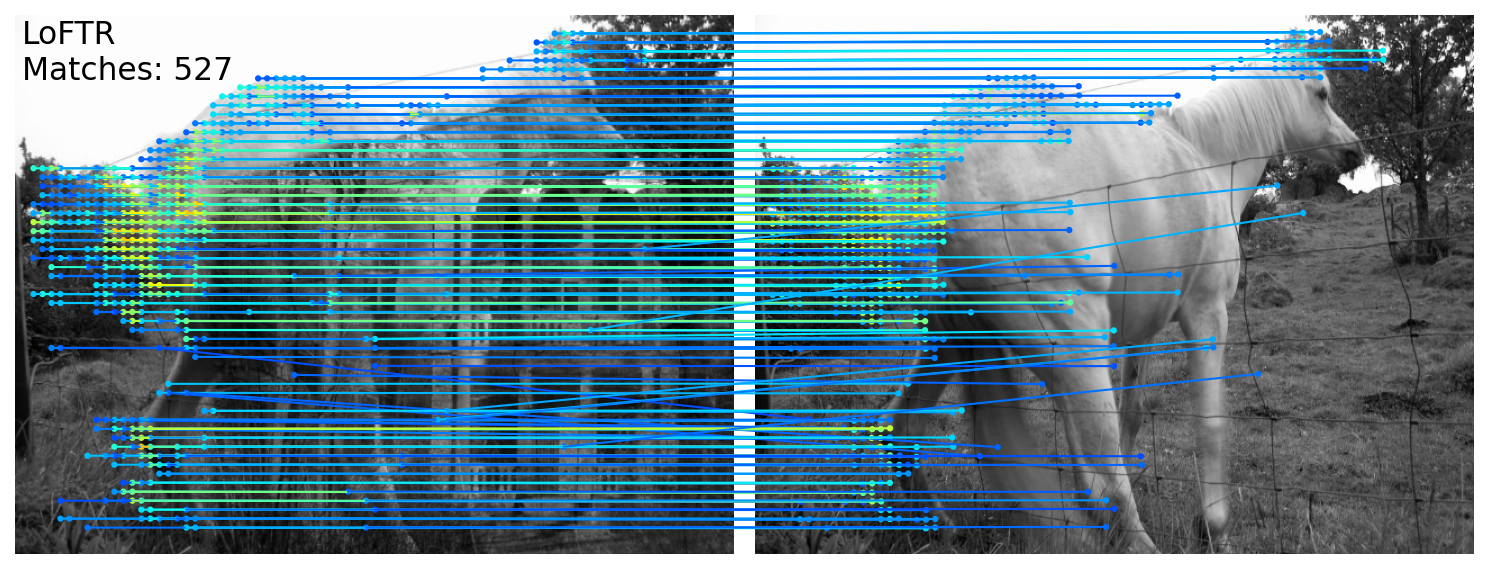

In [45]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

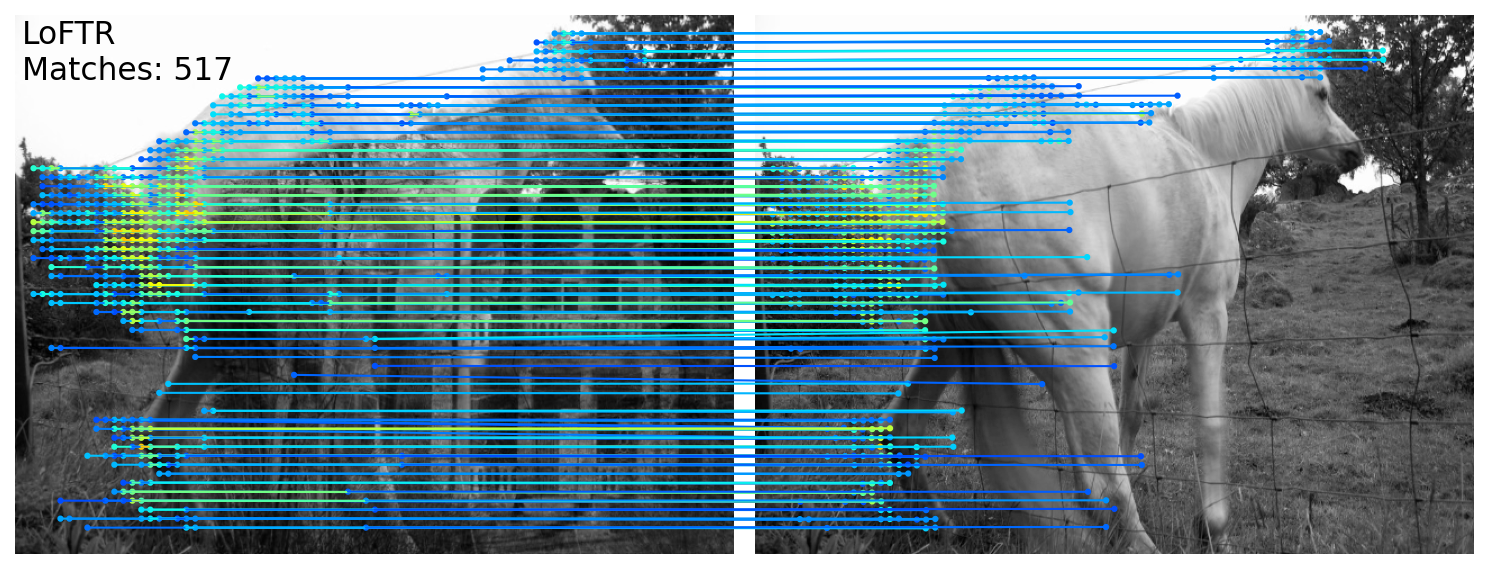

In [51]:
# Draw
color = cm.jet(mconf[inliers])
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0[inliers])),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0[inliers], mkpts1[inliers], color, text=text)

In [5]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        query_ids,
        reference_ids,
    ):
        self.query_ids = query_ids
        self.reference_ids = reference_ids

    def __len__(self):
        return len(self.reference_ids)

    def __getitem__(self, i):
        qid = self.query_ids[i]
        rid = self.reference_ids[i]
        img0_pth = f'/mnt/sdb/yokoo/fbisc/input/query_images/{qid}.jpg'
        img1_pth = f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg'
        img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
        img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
        img0_raw = cv2.resize(img0_raw, (640, 480))
        img1_raw = cv2.resize(img1_raw, (640, 480))
        img0 = torch.from_numpy(img0_raw)[None] / 255.
        img1 = torch.from_numpy(img1_raw)[None] / 255.
        return qid, rid, img0, img1

# sub = sub.sort_values('score', ascending=False)

dataset = PairDataset(sub['query_id'].values, sub['reference_id'].values)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [ ]:
num_matches = []

with h5py.File('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.h5', 'w') as f:

    for qids, rids, img0, img1 in tqdm(loader):
        img0 = img0.to('cuda')
        img1 = img1.to('cuda')

        batch = {'image0': img0, 'image1': img1}

        with torch.no_grad():
            mkpts0_f, mkpts1_f, m_bids = matcher(batch)
            mkpts0_f = mkpts0_f.cpu().numpy()
            mkpts1_f = mkpts1_f.cpu().numpy()
            m_bids = m_bids.cpu().numpy()
            num_matches.extend(np.bincount(m_bids, minlength=len(qids)).tolist())

        for ind in np.unique(m_bids):
            qid = qids[ind]
            rid = rids[ind]

            f.create_dataset(f'/{qid}/{rid}/mkpts0', data=mkpts0_f[m_bids == ind])
            f.create_dataset(f'/{qid}/{rid}/mkpts1', data=mkpts1_f[m_bids == ind])

In [7]:
matches = pd.DataFrame()
matches['query_id'] = sub['query_id']
matches['reference_id'] = sub['reference_id']
matches['num_matches'] = num_matches
matches.to_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv', index=False)

# RANSAC

In [ ]:
import cv2
cv2.setNumThreads(0)
import os
import concurrent.futures as confu

import pandas as pd
from tqdm import tqdm
import h5py
from skimage.transform import AffineTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.measure import ransac

def count_inliers(row):
    if row['num_matches'] < 7:
        return 0

    mkpts0 = f[f"/{row['query_id']}/{row['reference_id']}/mkpts0"][()]
    mkpts1 = f[f"/{row['query_id']}/{row['reference_id']}/mkpts1"][()]

#     model_robust, inliers = ransac((mkpts0, mkpts1), AffineTransform, min_samples=3, residual_threshold=20, max_trials=1000)
#     return 0 if inliers is None else sum(inliers)

    _, mask = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC)

    return mask.sum()

matches = pd.read_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv')

with h5py.File('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.h5', 'r') as f:
    with confu.ProcessPoolExecutor(max_workers=os.cpu_count()) as pool:
        with tqdm(total=len(matches)) as progress:
            futures = []
            result = []

            for _, row in matches.iterrows():
                future = pool.submit(count_inliers, row)
                future.add_done_callback(lambda p: progress.update())
                futures.append(future)

            (done, notdone) = confu.wait(futures)
            results = []
            for future in futures:
                result = future.result()
                results.append(result)

matches['num_inliers'] = results
matches.to_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv', index=False)

matches = pd.read_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv')
sub_ = sub.drop(['num_matches', 'num_inliers'], axis=1).merge(matches, on=['query_id', 'reference_id'], how='left').copy()

# sub_.loc[sub_['num_inliers'].notna(), 'score'] += np.log1p(sub_.loc[sub_['num_inliers'].notna(), 'num_inliers']) / 25
sub_.loc[sub_['num_inliers'].notna(), 'score'] += sub_.loc[sub_['num_inliers'].notna(), 'num_inliers'] / 2500
sub_.iloc[:, :3].to_csv('/home/shuhei.yokoo/fbisc/notebooks/tmp.csv', index=False)

In [16]:
matches = pd.read_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv')

In [22]:
sub_ = sub.copy()
sub_['num_matches'] = matches['num_matches']

# sub_.loc[sub_['num_matches'].notna(), 'score'] += np.log1p(sub_.loc[sub_['num_matches'].notna(), 'num_matches']) / 25
sub_.loc[sub_['num_matches'].notna(), 'score'] += sub_.loc[sub_['num_matches'].notna(), 'num_matches'] / 3000
sub_.iloc[:, :3].to_csv('/home/shuhei.yokoo/fbisc/notebooks/tmp.csv', index=False)

3000
{
  "average_precision": 0.5582950710426607,
  "recall_p90": 0.46363454217591665
}

{'average_precision': 0.5582950710426607, 'recall_p90': 0.46363454217591665}

In [13]:
sub_ = sub.copy()
sub_['num_inliers'] = matches['num_inliers']

# sub_.loc[sub_['num_inliers'].notna(), 'score'] += np.log1p(sub_.loc[sub_['num_inliers'].notna(), 'num_inliers']) / 25
sub_.loc[sub_['num_inliers'].notna(), 'score'] += sub_.loc[sub_['num_inliers'].notna(), 'num_inliers'] / 2000
sub_.iloc[:, :3].to_csv('/home/shuhei.yokoo/fbisc/notebooks/tmp.csv', index=False)

3000
{
  "average_precision": 0.5582950710426607,
  "recall_p90": 0.46363454217591665
}

{'average_precision': 0.5582950710426607, 'recall_p90': 0.46363454217591665}

# add new q-r pair

In [19]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        query_ids,
        reference_ids,
    ):
        self.query_ids = query_ids
        self.reference_ids = reference_ids

    def __len__(self):
        return len(self.reference_ids)

    def __getitem__(self, i):
        qid = self.query_ids[i]
        rid = self.reference_ids[i]
        img0_pth = f'/mnt/sdb/yokoo/fbisc/input/query_images/{qid}.jpg'
        img1_pth = f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg'
        img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
        img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
        img0_raw = cv2.resize(img0_raw, (640, 480))
        img1_raw = cv2.resize(img1_raw, (640, 480))
        img0 = torch.from_numpy(img0_raw)[None] / 255.
        img1 = torch.from_numpy(img1_raw)[None] / 255.
        return qid, rid, img0, img1

matches = pd.read_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv')
sub = sub.merge(matches, on=['query_id', 'reference_id'], how='left')
tmp = sub[sub['num_matches'].isna()]

dataset = PairDataset(tmp['query_id'].values, tmp['reference_id'].values)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [ ]:
num_matches = []

with h5py.File('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.h5', 'a') as f:

    for qids, rids, img0, img1 in tqdm(loader):
        img0 = img0.to('cuda')
        img1 = img1.to('cuda')

        batch = {'image0': img0, 'image1': img1}

        with torch.no_grad():
            mkpts0_f, mkpts1_f, m_bids = matcher(batch)
            mkpts0_f = mkpts0_f.cpu().numpy()
            mkpts1_f = mkpts1_f.cpu().numpy()
            m_bids = m_bids.cpu().numpy()
            num_matches.extend(np.bincount(m_bids, minlength=len(qids)).tolist())

        for ind in np.unique(m_bids):
            qid = qids[ind]
            rid = rids[ind]

            f.create_dataset(f'/{qid}/{rid}/mkpts0', data=mkpts0_f[m_bids == ind])
            f.create_dataset(f'/{qid}/{rid}/mkpts1', data=mkpts1_f[m_bids == ind])

In [26]:
sub.loc[sub['num_matches'].isna(), 'num_matches'] = num_matches

In [61]:
sub_ = sub.copy()

# sub_.loc[sub_['num_matches'].notna(), 'score'] += np.log1p(sub_.loc[sub_['num_matches'].notna(), 'num_matches']) / 20
sub_.loc[sub_['num_matches'].notna(), 'score'] += sub_.loc[sub_['num_matches'].notna(), 'num_matches'] / 3000
sub_.iloc[:, :3].to_csv('/home/shuhei.yokoo/fbisc/notebooks/tmp.csv', index=False)

3000
{
  "average_precision": 0.6301642178240727,
  "recall_p90": 0.5547986375475856
}

{'average_precision': 0.6301642178240727, 'recall_p90': 0.5547986375475856}

In [37]:
matches = matches.append(sub.drop('score', axis=1)).drop_duplicates(['query_id', 'reference_id'])
matches.to_csv('/home/shuhei.yokoo/fbisc/output/matches_indoor_ds.csv', index=False)